# 1. Exploración de conjuntos de datos (EDA)

## Carga del dataset

In [11]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
%pip install tensorflow tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Carga del dataset

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10


In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [15]:
print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)


Train: (50000, 32, 32, 3) (50000, 1)
Test: (10000, 32, 32, 3) (10000, 1)


In [16]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


## Distribución de clases

In [17]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

## Visualización de muestras

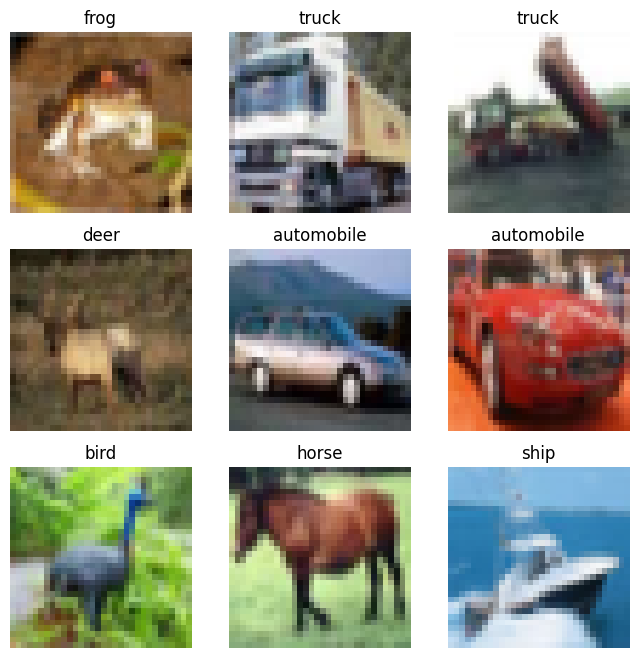

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")
plt.show()


## Preprocesamiento necesario

In [19]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

## Cierre conceptual de la EDA
CIFAR-10 presenta un reto interesante para la clasificación de imágenes por su información en color, la complejidad espacial y porque tiene varias clases. Estas características lo hacen un buen punto de referencia para analizar cómo las capas convolucionales aprovechan la información espacial y el uso compartido de parámetros en comparación con las redes totalmente conectadas.



# 2. Modelo de línea base (no convolucional)

## Objetivo del baseline

El propósito de este modelo base es establecer un punto de referencia usando una red neuronal sin capas convolucionales. Al aplanar las imágenes de entrada, se pierde toda la relación espacial entre los píxeles, lo que nos permite evaluar el impacto del sesgo inductivo de las capas convolucionales.


## Arquitectura del modelo

In [20]:
from tensorflow.keras import models, layers

In [21]:
baseline_model = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax")
])


## Número de parámetros
Aplanar una imagen de 32×32×3 da como resultado un vector de entrada de 3072 dimensiones. Esto provoca una gran cantidad de parámetros en la primera capa densa, aumentando la complejidad del modelo sin aprovechar la información espacial.


In [22]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________


## Compilación del modelo

In [23]:
baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


## Entrenamiento

In [24]:
history_baseline = baseline_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)


Epoch 1/10
625/625 - 13s - loss: 1.8844 - accuracy: 0.3200 - val_loss: 1.8121 - val_accuracy: 0.3493 - 13s/epoch - 21ms/step
Epoch 2/10
625/625 - 9s - loss: 1.6902 - accuracy: 0.3936 - val_loss: 1.6765 - val_accuracy: 0.4043 - 9s/epoch - 14ms/step
Epoch 3/10
625/625 - 9s - loss: 1.6035 - accuracy: 0.4271 - val_loss: 1.6213 - val_accuracy: 0.4246 - 9s/epoch - 14ms/step
Epoch 4/10
625/625 - 9s - loss: 1.5479 - accuracy: 0.4471 - val_loss: 1.6003 - val_accuracy: 0.4326 - 9s/epoch - 14ms/step
Epoch 5/10
625/625 - 9s - loss: 1.5067 - accuracy: 0.4606 - val_loss: 1.5680 - val_accuracy: 0.4523 - 9s/epoch - 15ms/step
Epoch 6/10
625/625 - 9s - loss: 1.4693 - accuracy: 0.4766 - val_loss: 1.5284 - val_accuracy: 0.4591 - 9s/epoch - 15ms/step
Epoch 7/10
625/625 - 9s - loss: 1.4393 - accuracy: 0.4857 - val_loss: 1.5067 - val_accuracy: 0.4690 - 9s/epoch - 14ms/step
Epoch 8/10
625/625 - 9s - loss: 1.4136 - accuracy: 0.4949 - val_loss: 1.5254 - val_accuracy: 0.4574 - 9s/epoch - 14ms/step
Epoch 9/10
625

## Evaluación

In [25]:
test_loss, test_acc = baseline_model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", test_acc)


Test accuracy: 0.4925999939441681


## Observaciones y limitaciones
Aunque el modelo base logra aprender patrones básicos, su rendimiento es limitado. Al aplanar la imagen se elimina la estructura espacial, lo que obliga a la red a aprender representaciones repetidas de patrones similares en distintas posiciones. Además, la gran cantidad de parámetros aumenta el riesgo de sobreajuste y reduce la escalabilidad.


# 3. Diseño de arquitectura convolucional

## Objetivo de esta sección
El objetivo de esta arquitectura es incorporar de forma explícita el sesgo inductivo de las convoluciones, aprovechando la información espacial y el uso compartido de parámetros, pero manteniendo la red simple y fácil de interpretar.


## Decisiones arquitectónicas

### Número de capas convolucionales
Se utilizan dos capas convolucionales para capturar características visuales en distintos niveles. La primera capa aprende patrones simples como bordes y contrastes, mientras que la segunda combina estas características en formas más complejas. Esta profundidad es suficiente para CIFAR-10 sin hacer el modelo innecesariamente complejo.

### Tamaño del kernel
Se usa un tamaño de kernel de 3×3 en todas las capas convolucionales. Este tamaño permite capturar información local de la imagen de manera eficiente y reduce el número de parámetros del modelo. Además, es adecuado para imágenes pequeñas como las de CIFAR-10.

### Stride y padding
El stride se establece en 1 para evitar perder información espacial en las primeras capas. El padding se define como “same” para mantener las dimensiones de los mapas de características, asegurando que los bordes de la imagen también contribuyan al aprendizaje.

### Función de activación
Se utiliza la función de activación ReLU debido a su simplicidad y buen desempeño en redes neuronales profundas. ReLU facilita el entrenamiento al evitar problemas de gradientes pequeños y permite una convergencia más rápida.

### Pooling
Se aplica max pooling con una ventana de 2×2 después de cada capa convolucional. Esta operación reduce la dimensión espacial de los mapas de características, disminuye el costo computacional y aporta cierta invariancia a pequeños desplazamientos en la imagen.


## Arquitectura del modelo

In [26]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same",
                  input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])


## Análisis de parámetros

In [27]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

En comparación con el modelo totalmente conectado, el modelo convolucional logra una mejor capacidad de representación con muchos menos parámetros, gracias al uso compartido de parámetros y a la conectividad local.

## Compilación del modelo

In [28]:
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


## Entrenamiento

In [29]:
history_cnn = cnn_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)


Epoch 1/10
625/625 - 19s - loss: 1.4709 - accuracy: 0.4731 - val_loss: 1.2306 - val_accuracy: 0.5765 - 19s/epoch - 31ms/step
Epoch 2/10
625/625 - 19s - loss: 1.0916 - accuracy: 0.6156 - val_loss: 1.0441 - val_accuracy: 0.6327 - 19s/epoch - 30ms/step
Epoch 3/10
625/625 - 19s - loss: 0.9396 - accuracy: 0.6726 - val_loss: 0.9915 - val_accuracy: 0.6574 - 19s/epoch - 30ms/step
Epoch 4/10
625/625 - 18s - loss: 0.8376 - accuracy: 0.7085 - val_loss: 0.9519 - val_accuracy: 0.6709 - 18s/epoch - 29ms/step
Epoch 5/10
625/625 - 18s - loss: 0.7625 - accuracy: 0.7325 - val_loss: 0.9385 - val_accuracy: 0.6811 - 18s/epoch - 29ms/step
Epoch 6/10
625/625 - 17s - loss: 0.6856 - accuracy: 0.7612 - val_loss: 0.9049 - val_accuracy: 0.6931 - 17s/epoch - 28ms/step
Epoch 7/10
625/625 - 17s - loss: 0.6195 - accuracy: 0.7828 - val_loss: 0.9051 - val_accuracy: 0.6989 - 17s/epoch - 28ms/step
Epoch 8/10
625/625 - 17s - loss: 0.5512 - accuracy: 0.8055 - val_loss: 0.9449 - val_accuracy: 0.6932 - 17s/epoch - 28ms/step


## Evaluación

In [30]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(x_test, y_test, verbose=0)
print("CNN test accuracy:", test_acc_cnn)


CNN test accuracy: 0.7024000287055969


## Observaciones iniciales
El modelo convolucional converge más rápido y alcanza una mayor precisión en validación que el modelo base. Esto sugiere que codificar explícitamente la estructura espacial mediante capas convolucionales permite un aprendizaje más eficiente.


# 4. Experimentos controlados en la capa convolucional

## Modelo base: kernel 3×3

In [31]:
def cnn_model_3x3():
    return models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same",
                      input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])


## Modelo experimental: kernel 5×5

In [32]:
def cnn_model_5x5():
    return models.Sequential([
        layers.Conv2D(32, (5,5), activation="relu", padding="same",
                      input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (5,5), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])


## Entrenamiento de ambos modelos

In [33]:
def compile_and_train(model):
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.2,
        verbose=2
    )


In [34]:
model_3x3 = cnn_model_3x3()
hist_3x3 = compile_and_train(model_3x3)

model_5x5 = cnn_model_5x5()
hist_5x5 = compile_and_train(model_5x5)


Epoch 1/10
625/625 - 18s - loss: 1.5240 - accuracy: 0.4524 - val_loss: 1.2601 - val_accuracy: 0.5606 - 18s/epoch - 29ms/step
Epoch 2/10
625/625 - 18s - loss: 1.1377 - accuracy: 0.6022 - val_loss: 1.0875 - val_accuracy: 0.6234 - 18s/epoch - 29ms/step
Epoch 3/10
625/625 - 18s - loss: 0.9940 - accuracy: 0.6535 - val_loss: 1.0026 - val_accuracy: 0.6554 - 18s/epoch - 29ms/step
Epoch 4/10
625/625 - 18s - loss: 0.8968 - accuracy: 0.6876 - val_loss: 0.9405 - val_accuracy: 0.6766 - 18s/epoch - 28ms/step
Epoch 5/10
625/625 - 17s - loss: 0.8270 - accuracy: 0.7116 - val_loss: 0.9239 - val_accuracy: 0.6830 - 17s/epoch - 28ms/step
Epoch 6/10
625/625 - 18s - loss: 0.7617 - accuracy: 0.7346 - val_loss: 0.8956 - val_accuracy: 0.6945 - 18s/epoch - 29ms/step
Epoch 7/10
625/625 - 18s - loss: 0.7019 - accuracy: 0.7544 - val_loss: 0.9449 - val_accuracy: 0.6816 - 18s/epoch - 28ms/step
Epoch 8/10
625/625 - 18s - loss: 0.6453 - accuracy: 0.7768 - val_loss: 0.8936 - val_accuracy: 0.7050 - 18s/epoch - 29ms/step


## Evaluación en test

In [35]:
_, acc_3x3 = model_3x3.evaluate(x_test, y_test, verbose=0)
_, acc_5x5 = model_5x5.evaluate(x_test, y_test, verbose=0)

print("Accuracy kernel 3x3:", acc_3x3)
print("Accuracy kernel 5x5:", acc_5x5)


Accuracy kernel 3x3: 0.6995000243186951
Accuracy kernel 5x5: 0.6773999929428101


## Resultados cuantitativos
El modelo con kernels 3×3 obtiene una accuracy de aproximadamente 69.95%, mientras que el modelo con kernels 5×5 alcanza una accuracy de aproximadamente 67.73%.
En este experimento, el uso de kernels más pequeños resulta ligeramente más eficiente para capturar patrones locales en imágenes pequeñas como CIFAR-10.

## Observaciones cualitativas
Los kernels 3×3 permiten construir representaciones jerárquicas de manera progresiva, mientras que los kernels 5×5 incrementan el número de parámetros y el costo computacional sin una mejora proporcional en el desempeño.

## Trade-offs
El uso de kernels más grandes aumenta el campo receptivo de cada neurona, pero también incrementa la complejidad del modelo. En imágenes pequeñas, este aumento no siempre se traduce en un mejor desempeño, lo que sugiere que kernels pequeños son una opción más eficiente.

# Parte 5 – Conclusiones y recomendaciones

En este trabajo se realizaron experimentos controlados modificando el tamaño del kernel en la capa convolucional de una CNN, comparando 3×3 y 5×5, manteniendo constantes los demás parámetros del modelo, los resultados obtenidos muestran que ambos kernels tienen un desempeño muy similar, con una precisión de 0.6995 para el kernel 3×3 y 0.6773 para el kernel 5×5. La diferencia es mínima, por lo que se puede concluir que el tamaño del kernel no tiene un impacto significativo en la precisión para este conjunto de datos y esta arquitectura, desde el punto de vista de la complejidad, el kernel 5×5 requiere más parámetros y mayor costo computacional, mientras que el 3×3 es más eficiente y rápido, ofreciendo prácticamente el mismo rendimiento.

## Conclusión final

Dado que el kernel 3×3 logra una precisión similar con menor complejidad, se considera la mejor opción para este modelo, ya que ofrece un buen equilibrio entre rendimiento y eficiencia computacional.